In [17]:
import sys, os

sys.path.append('../../zero-shot-absa-quad/')

from dataloader import DataLoader
dataloader = DataLoader(base_path="../../zero-shot-absa-quad/datasets/")

In [18]:
datasets = ["rest15", "rest16", "flightabsa", "hotels", "coursera"]
polarities = ["positive", "negative", "neutral"]
tasks = ["tasd", "asqp"]

In [19]:
dataloader.load_data(name="rest16", data_type="all", target="tasd")[0]

{'id': '0_rest16_../../zero-shot-absa-quad/datasets/tasd/rest16/train.txt',
 'text': 'Judging from previous posts this used to be a good place , but not any longer .',
 'aspects': [{'aspect_category': 'restaurant general',
   'polarity': 'negative',
   'aspect_term': 'place'}],
 'tuple_list': [('place', 'restaurant general', 'negative')]}

In [20]:
from collections import defaultdict

# Lade das gesamte Dataset
data = dataloader.load_data(name="rest16", data_type="all", target="tasd")

# Erstelle ein Dictionary zum Zählen der Kategorien
category_count = defaultdict(int)

# Iteriere über alle Beispiele und Aspekte
for example in data:
    for aspect in example['aspects']:
        category = aspect['aspect_category']
        category_count[category] += 1

# Ausgabe des Dictionarys
print(category_count)

defaultdict(<class 'int'>, {'restaurant general': 574, 'service general': 611, 'food quality': 1178, 'food style_options': 194, 'drinks style_options': 45, 'drinks prices': 25, 'restaurant prices': 103, 'restaurant miscellaneous': 132, 'ambience general': 325, 'food prices': 113, 'location general': 41, 'drinks quality': 69})


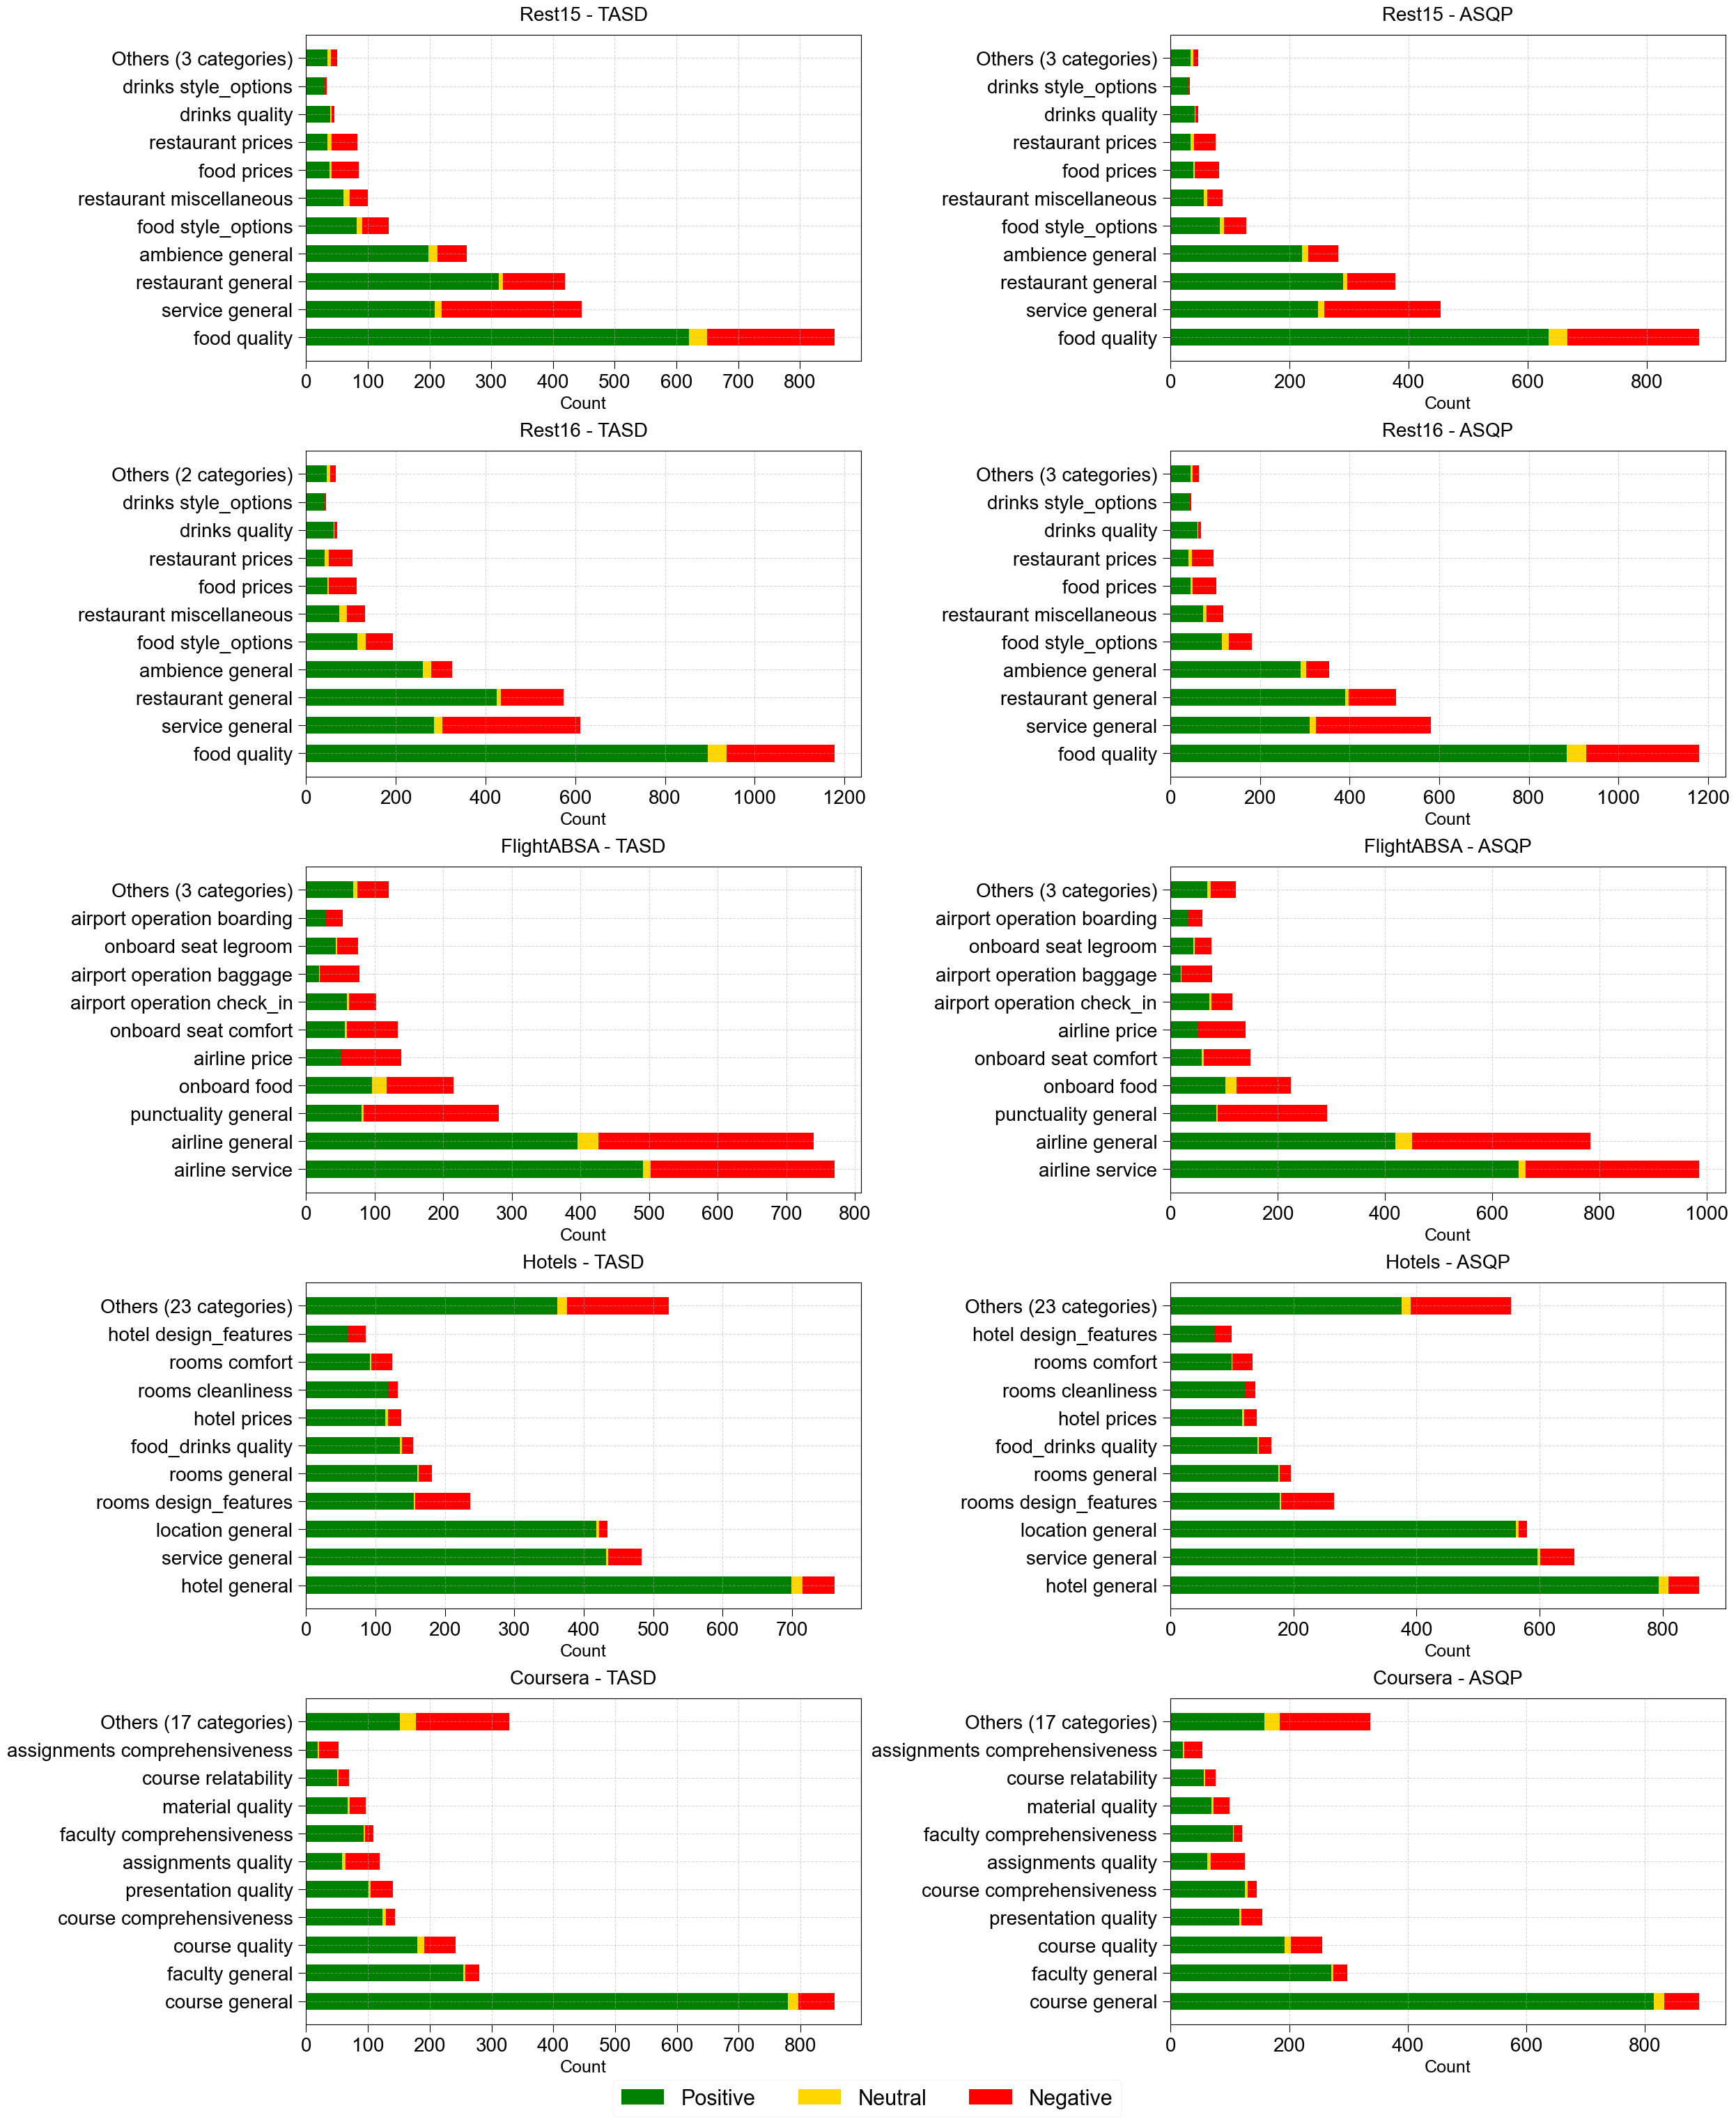

Summary of Aspect Sentiment Distributions:
Rest15 - TASD: Positive: 1658, Neutral: 98, Negative: 756, Total Aspects: 2512
Rest15 - ASQP: Positive: 1710, Neutral: 85, Negative: 701, Total Aspects: 2496
Rest16 - TASD: Positive: 2291, Neutral: 146, Negative: 973, Total Aspects: 3410
Rest16 - ASQP: Positive: 2293, Neutral: 125, Negative: 877, Total Aspects: 3295
FlightABSA - TASD: Positive: 1389, Neutral: 82, Negative: 1237, Total Aspects: 2708
FlightABSA - ASQP: Positive: 1600, Neutral: 85, Negative: 1339, Total Aspects: 3024
Hotels - TASD: Positive: 2745, Neutral: 50, Negative: 455, Total Aspects: 3250
Hotels - ASQP: Positive: 3230, Neutral: 52, Negative: 502, Total Aspects: 3784
Coursera - TASD: Positive: 1877, Neutral: 82, Negative: 478, Total Aspects: 2437
Coursera - ASQP: Positive: 1990, Neutral: 82, Negative: 486, Total Aspects: 2558


In [21]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from collections import defaultdict
import os

# Set up font
font_path = '_fonts/arial.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.style.use('seaborn-v0_8-paper')

# Title mappings
dataset_titles = {
    "rest15": "Rest15",
    "rest16": "Rest16",
    "flightabsa": "FlightABSA",
    "coursera": "Coursera",
    "hotels": "Hotels"
}
task_titles = {
    "tasd": "TASD",
    "asqp": "ASQP"
}

# Colors for polarities
colors = {'positive': 'green', 'neutral': 'gold', 'negative': 'red'}

# Create subplots 5x2 with wider figure
fig, axes = plt.subplots(5, 2, figsize=(25, 30))
axes = axes.flatten()

plot_idx = 0

# Dictionary to store summary statistics
summary_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for dataset in datasets:
    for task in tasks:
        # Load data
        data = dataloader.load_data(name=dataset, data_type="all", target=task)
        
        # Count categories and polarities
        category_polarity_count = defaultdict(lambda: defaultdict(int))
        total_positive = 0
        total_neutral = 0
        total_negative = 0
        for example in data:
            for aspect in example['aspects']:
                category = aspect['aspect_category']
                polarity = aspect['polarity']
                category_polarity_count[category][polarity] += 1
                if polarity == 'positive':
                    total_positive += 1
                elif polarity == 'neutral':
                    total_neutral += 1
                elif polarity == 'negative':
                    total_negative += 1
        
        # Store totals for summary
        summary_stats[dataset][task]['positive'] = total_positive
        summary_stats[dataset][task]['neutral'] = total_neutral
        summary_stats[dataset][task]['negative'] = total_negative
        
        # Prepare data for plot
        categories = list(category_polarity_count.keys())
        positives = [category_polarity_count[cat]['positive'] for cat in categories]
        neutrals = [category_polarity_count[cat]['neutral'] for cat in categories]
        negatives = [category_polarity_count[cat]['negative'] for cat in categories]
        
        # Sort by total frequency descending
        totals = [p + n + neg for p, n, neg in zip(positives, neutrals, negatives)]
        sorted_indices = sorted(range(len(totals)), key=lambda i: totals[i], reverse=True)
        categories = [categories[i] for i in sorted_indices]
        positives = [positives[i] for i in sorted_indices]
        neutrals = [neutrals[i] for i in sorted_indices]
        negatives = [negatives[i] for i in sorted_indices]
        
        # Limit to top-10 and group rest as 'Others'
        if len(categories) > 10:
            top_categories = categories[:10]
            top_positives = positives[:10]
            top_neutrals = neutrals[:10]
            top_negatives = negatives[:10]
            
            others_pos = sum(positives[10:])
            others_neu = sum(neutrals[10:])
            others_neg = sum(negatives[10:])
            
            num_others = len(categories) - 10
            categories = top_categories + [f'Others ({num_others} categories)']
            positives = top_positives + [others_pos]
            neutrals = top_neutrals + [others_neu]
            negatives = top_negatives + [others_neg]
        
        # Plot stacked bars
        ax = axes[plot_idx]
        ax.barh(categories, positives, color='green', label='Positive', height=0.6)
        ax.barh(categories, neutrals, left=positives, color='gold', label='Neutral', height=0.6)
        ax.barh(categories, negatives, left=[p + n for p, n in zip(positives, neutrals)], color='red', label='Negative', height=0.6)
        
        ax.set_title(f'{dataset_titles[dataset]} - {task_titles[task]}', fontsize=20, pad=15)
        ax.set_xlabel('Count', fontsize=18)
        # Set ylabel only for right plots (odd indices)
        # if plot_idx % 2 == 1:
        #     ax.set_ylabel('Aspect Categories', fontsize=16)
        # ax.legend(fontsize=14)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.tick_params(axis='both', length=8)
        ax.grid(True, linestyle='--', alpha=0.5)
        
        plot_idx += 1

# Add a common legend below the plots
fig.legend(['Positive', 'Neutral', 'Negative'], loc='lower center', fontsize=22, ncol=3, bbox_to_anchor=(0.5, -0.02))

# Adjust layout to make space for the legend
plt.subplots_adjust(bottom=0.15)

plt.tight_layout()
fig.savefig('_out_table/ac_pol_dist.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics for caption
print("Summary of Aspect Sentiment Distributions:")
for dataset in datasets:
    for task in tasks:
        pos = summary_stats[dataset][task]['positive']
        neu = summary_stats[dataset][task]['neutral']
        neg = summary_stats[dataset][task]['negative']
        total = pos + neu + neg
        print(f"{dataset_titles[dataset]} - {task_titles[task]}: Positive: {pos}, Neutral: {neu}, Negative: {neg}, Total Aspects: {total}")